# ASSIGNMENT 1: MEAN WIND SPEED AND THE WEIBULL DISTRIBUTION

## Imports

In [39]:
import pandas as pd
import numpy as np
from scipy.special import gamma
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d
from sympy import symbols, Eq, nsolve, exp, gamma

## Read Data

In [2]:
headers = ['timestamp', 'wind_speed', 'wind_direction_67.5m', 'wind_direction_70m']

In [3]:
sprog = pd.read_csv("sprog.tsv", sep='\t', header=None, names=headers)

In [4]:
sprog

,timestamp,wind_speed,wind_direction_67.5m,wind_direction_70m
0,197709131435,9.76,317.0,999.0
1,197709131445,10.58,309.0,999.0
2,197709131455,10.19,329.0,999.0
3,197709131505,8.71,323.0,999.0
4,197709131515,8.85,309.0,999.0
...,...,...,...,...
1156272,199909080635,4.20,999.0,222.0
1156273,199909080645,4.77,999.0,226.0
1156274,199909080655,5.37,999.0,233.0
1156275,199909080705,5.07,999.0,230.0


In [5]:
headers_2 = ['timestamp', 'sm_vel_component']

In [6]:
hovsore_1 = pd.read_csv('hovsore_1.txt', header=None, names= headers_2)

In [7]:
hovsore_1

,timestamp,sm_vel_component
0,201603012000,9.49
1,201603012000,10.16
2,201603012000,9.71
3,201603012000,10.79
4,201603012000,10.84
...,...,...
287995,201603012350,12.60
287996,201603012350,13.54
287997,201603012350,13.00
287998,201603012350,12.90


## Data Cleaning

Both datasets will be cleaned to remove all error measurements

### Sprog

First we convert all non-numerical values to NaN, those non-numerical values must correspond to error flags.

In [8]:
sprog = sprog.apply(pd.to_numeric, errors='coerce')

In [9]:
sprog

,timestamp,wind_speed,wind_direction_67.5m,wind_direction_70m
0,197709131435,9.76,317.0,999.0
1,197709131445,10.58,309.0,999.0
2,197709131455,10.19,329.0,999.0
3,197709131505,8.71,323.0,999.0
4,197709131515,8.85,309.0,999.0
...,...,...,...,...
1156272,199909080635,4.20,999.0,222.0
1156273,199909080645,4.77,999.0,226.0
1156274,199909080655,5.37,999.0,233.0
1156275,199909080705,5.07,999.0,230.0


#### Wind Direction

Apart from the non-numerical values, the other wind direction values that shouldn't be correct data are the ones over 360 or below 0. This could come from an error measurement (999 in this case) or the wind direction measurement is not normalised at 0 - 360 and getting multiples of those values. Let's find those values over 360 and below 0.

In [10]:
unique_below_0_wind_67_5 = sprog['wind_direction_67.5m'][sprog['wind_direction_67.5m'] < 0].unique()
unique_below_0_wind_70 = sprog['wind_direction_70m'][sprog['wind_direction_70m'] < 0].unique()

unique_over_360_wind_67_5 = sprog['wind_direction_67.5m'][sprog['wind_direction_67.5m'] > 360].unique()
unique_over_360_wind_70 = sprog['wind_direction_70m'][sprog['wind_direction_70m'] > 360].unique()

unique_values_over_360_and_below_0 = set(unique_below_0_wind_67_5).union(set(unique_below_0_wind_70), 
                                                                        set(unique_over_360_wind_67_5), 
                                                                        set(unique_over_360_wind_70))


In [11]:
unique_values_over_360_and_below_0

{999.0}

It turns out that the measurements are already normalised to a range of 0 to 360 degrees, however we find 999 measurements which are classified as error. Thise values are converter no NaN. 

In [12]:
sprog.replace(999, np.nan, inplace=True)

In [13]:
sprog

,timestamp,wind_speed,wind_direction_67.5m,wind_direction_70m
0,197709131435,9.76,317.0,NaN
1,197709131445,10.58,309.0,NaN
2,197709131455,10.19,329.0,NaN
3,197709131505,8.71,323.0,NaN
4,197709131515,8.85,309.0,NaN
...,...,...,...,...
1156272,199909080635,4.20,NaN,222.0
1156273,199909080645,4.77,NaN,226.0
1156274,199909080655,5.37,NaN,233.0
1156275,199909080705,5.07,NaN,230.0


As we want to work with just a wind direction value form now on, there is the possibility of using one of the two measurements of the wind direction or getting a mean out of it, let's look at the timestamps when we have two correct values in both height measurements. As there is just a difference of 2.5m in height. 

In [14]:
filtered_df = sprog.dropna(subset=['wind_direction_67.5m', 'wind_direction_70m'])

In [15]:
filtered_df

,timestamp,wind_speed,wind_direction_67.5m,wind_direction_70m


It is seen that there are no timestamps when the two measurements (67.5 and 70 meters) have a proper measurement at the same time, thus a unique wind direction vector is created using one measurement or the other.

In [16]:
sprog['wind_direction'] = sprog['wind_direction_67.5m'].combine_first(sprog['wind_direction_70m'])

In [17]:
sprog

,timestamp,wind_speed,wind_direction_67.5m,wind_direction_70m,wind_direction
0,197709131435,9.76,317.0,NaN,317.0
1,197709131445,10.58,309.0,NaN,309.0
2,197709131455,10.19,329.0,NaN,329.0
3,197709131505,8.71,323.0,NaN,323.0
4,197709131515,8.85,309.0,NaN,309.0
...,...,...,...,...,...
1156272,199909080635,4.20,NaN,222.0,222.0
1156273,199909080645,4.77,NaN,226.0,226.0
1156274,199909080655,5.37,NaN,233.0,233.0
1156275,199909080705,5.07,NaN,230.0,230.0


In [18]:
sprog[sprog['wind_direction_67.5m'].isna() & sprog['wind_direction_70m'].notna()]

,timestamp,wind_speed,wind_direction_67.5m,wind_direction_70m,wind_direction
595497,198901090005,9.74,NaN,264.0,264.0
595498,198901090015,9.87,NaN,261.0,261.0
595499,198901090025,9.13,NaN,258.0,258.0
595500,198901090035,8.90,NaN,260.0,260.0
595501,198901090045,9.06,NaN,262.0,262.0
...,...,...,...,...,...
1156272,199909080635,4.20,NaN,222.0,222.0
1156273,199909080645,4.77,NaN,226.0,226.0
1156274,199909080655,5.37,NaN,233.0,233.0
1156275,199909080705,5.07,NaN,230.0,230.0


In [19]:
sprog[sprog['wind_direction_67.5m'].isna()]

,timestamp,wind_speed,wind_direction_67.5m,wind_direction_70m,wind_direction
490,197709170015,99.99,NaN,NaN,NaN
491,197709170025,99.99,NaN,NaN,NaN
492,197709170035,99.99,NaN,NaN,NaN
493,197709170045,99.99,NaN,NaN,NaN
494,197709170055,99.99,NaN,NaN,NaN
...,...,...,...,...,...
1156272,199909080635,4.20,NaN,222.0,222.0
1156273,199909080645,4.77,NaN,226.0,226.0
1156274,199909080655,5.37,NaN,233.0,233.0
1156275,199909080705,5.07,NaN,230.0,230.0


#### Wind Speed

Now the wind speed measurements are checked. We'll look for cases where the wind speed measurement is incorrect. We set to find the values of wind_speed over 40 m/s and negative values.

In [20]:
unique_below_0_wind = sprog['wind_speed'][sprog['wind_speed'] < 0].unique()
unique_over_40_wind = sprog['wind_speed'][sprog['wind_speed'] > 40].unique()

unique_values_over_40_and_below_0 = set(unique_below_0_wind).union(set(unique_over_40_wind))

In [21]:
unique_values_over_40_and_below_0

{99.99}

Again the only invalid data is the one corresponding to 99.99 values, we'll convert those to NaN values.

In [22]:
sprog.replace(99.99, np.nan, inplace=True)

### Hovsore

This second datasate needs to be checked as well, we will apply the same filter as before, in this case there is only wind speed data available though.

In [23]:
hovsore_1 = hovsore_1.apply(pd.to_numeric, errors='coerce')

In [24]:
unique_below_0_wind = hovsore_1['sm_vel_component'][hovsore_1['sm_vel_component'] < 0].unique()
unique_over_40_wind = hovsore_1['sm_vel_component'][hovsore_1['sm_vel_component'] > 40].unique()

unique_values_over_40_and_below_0 = set(unique_below_0_wind).union(set(unique_over_40_wind))

In [25]:
unique_values_over_40_and_below_0

set()

No invalid data is found in the hovsore_1 dataset.

## Inspect the time-series

### 1)

Find the mean and standard deviation of wind speed from each data set.

#### Sprog

Mean Wind Speed

In [26]:
sprog_ws_mean = sprog['wind_speed'].mean()
print(sprog_ws_mean)

8.235566499681097


Wind Speed Standard deviation

In [27]:
sprog_ws_std = sprog['wind_speed'].std()
print(sprog_ws_std)

3.907913492060975


#### Hovsore 1

Mean Wind Speed

In [28]:
hovsore_1_mean = hovsore_1['sm_vel_component'].mean()
print(hovsore_1_mean)

13.295274895833645


Wind Speed Standard deviation

In [29]:
hovsore_1_std = hovsore_1['sm_vel_component'].std()
print(hovsore_1_std)

1.5435718228827797


### 2)

Appropriately calculate the mean and standard deviation of wind direction for the Sprogø
data, over the entire period.

It is needed to consider that the wind direction is cyclic, thus the mean can be calculated as it usually is. There are two ways to compute it: averaging wind vectors and averaging wind vectors disregarding the wind speed. It abviously be only calculated for Sprog dataset as is the only one with wind direction measurements.

#### Mean Wind direction - Averaging wind vectors

Rows with NaN values in either wind speed or wind direction will not be used for the calculation:

In [30]:
sprog_cleaned = sprog.dropna(subset=['wind_speed', 'wind_direction'])

Now compute $S_{va}$ as:

In [32]:
sprog_cleaned.loc[:, 'Sva'] = sprog_cleaned['wind_speed'] * np.sin(np.radians(sprog_cleaned['wind_direction']))

Sva = sprog_cleaned['Sva'].mean()
print(Sva)

-1.9060884150790651


C:\Users\alexm\AppData\Local\Temp/ipykernel_23612/4115743496.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sprog_cleaned.loc[:, 'Sva'] = sprog_cleaned['wind_speed'] * np.sin(np.radians(sprog_cleaned['wind_direction']))


Now compute $C_{va}$ as:

In [33]:
sprog_cleaned.loc[:, 'Cva'] = sprog_cleaned['wind_speed'] * np.cos(np.radians(sprog_cleaned['wind_direction']))

Cva = sprog_cleaned['Cva'].mean()
print(Cva)

-1.3037402558776214


C:\Users\alexm\AppData\Local\Temp/ipykernel_23612/804695814.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sprog_cleaned.loc[:, 'Cva'] = sprog_cleaned['wind_speed'] * np.cos(np.radians(sprog_cleaned['wind_direction']))


And the average wind direction:

In [34]:
Av_wd = (180/np.pi) * np.arctan2(Sva, Cva) % 360
print(Av_wd)

235.62836807151206


#### Mean Wind Direction - Disregarding the wind speed

In [35]:
sprog_cleaned.loc[:, 'Sa'] = np.sin(np.radians(sprog_cleaned['wind_direction']))

Sa = sprog_cleaned['Sa'].mean()
print(Sa)

-0.1878247020810765


C:\Users\alexm\AppData\Local\Temp/ipykernel_23612/2306913093.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sprog_cleaned.loc[:, 'Sa'] = np.sin(np.radians(sprog_cleaned['wind_direction']))


In [36]:
sprog_cleaned.loc[:, 'Ca'] = np.cos(np.radians(sprog_cleaned['wind_direction']))

Ca = sprog_cleaned['Ca'].mean()
print(Ca)

-0.13390632387921758


C:\Users\alexm\AppData\Local\Temp/ipykernel_23612/2008486381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sprog_cleaned.loc[:, 'Ca'] = np.cos(np.radians(sprog_cleaned['wind_direction']))


Then the average wind direction is:

In [37]:
Av_wd2 = ((180/np.pi) * np.arctan2(Sa, Ca)) % 360
print(Av_wd2)

234.5136969339993


#### Standard deviation Wind Direction

The Yamartino method is used to calculate the standard deviation.

In [38]:
ep = np.sqrt(1- Sa**2 - Ca**2)

std = np.arcsin(ep) * (1 + (2/(np.sqrt(3)) - 1) * ep**3)
print(std)

1.5287239953443936


### 3)

Plot the probability density function (PDF) of speed for each data set.

#### Sprog

In [40]:
sprog

,timestamp,wind_speed,wind_direction_67.5m,wind_direction_70m,wind_direction
0,197709131435,9.76,317.0,NaN,317.0
1,197709131445,10.58,309.0,NaN,309.0
2,197709131455,10.19,329.0,NaN,329.0
3,197709131505,8.71,323.0,NaN,323.0
4,197709131515,8.85,309.0,NaN,309.0
...,...,...,...,...,...
1156272,199909080635,4.20,NaN,222.0,222.0
1156273,199909080645,4.77,NaN,226.0,226.0
1156274,199909080655,5.37,NaN,233.0,233.0
1156275,199909080705,5.07,NaN,230.0,230.0


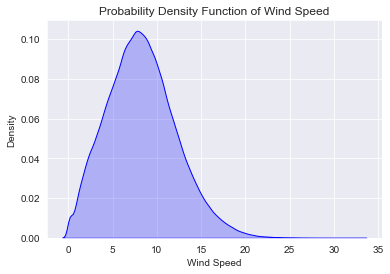

In [46]:
wind_speed = sprog['wind_speed'].dropna()

# Create the plot
sns.kdeplot(wind_speed, fill=True, color="blue")

# Adding title and labels
plt.title('Probability Density Function of Wind Speed')
plt.xlabel('Wind Speed')
plt.ylabel('Density')

# Save the plot to a file instead of showing it
plt.savefig('Task_3_1_wind_speed_pdf_sprog.png', dpi=300)  # Save it as a PNG file

# Display the plot
plt.show()

# Optionally, you can clear the figure to free up memory for future plots
#plt.clf()

#### Hovsore 1

In [44]:
hovsore_1

,timestamp,sm_vel_component
0,201603012000,9.49
1,201603012000,10.16
2,201603012000,9.71
3,201603012000,10.79
4,201603012000,10.84
...,...,...
287995,201603012350,12.60
287996,201603012350,13.54
287997,201603012350,13.00
287998,201603012350,12.90


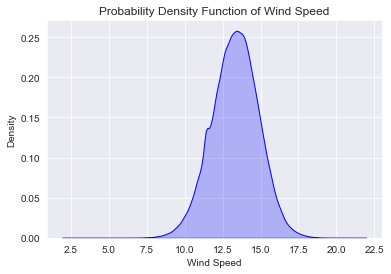

In [47]:
wind_speed = hovsore_1['sm_vel_component'].dropna()

# Create the plot
sns.kdeplot(wind_speed, fill=True, color="blue")

# Adding title and labels
plt.title('Probability Density Function of Wind Speed')
plt.xlabel('Wind Speed')
plt.ylabel('Density')

# Save the plot to a file instead of showing it
plt.savefig('Task_3_2_wind_speed_pdf_hovsore1.png', dpi=300)  # Save it as a PNG file

# Display the plot
plt.show()

# Optionally, you can clear the figure to free up memory for future plots
#plt.clf()

### 4)

Plot the cumulative distribution function (CDF) of speed for each data set.

#### Sprog

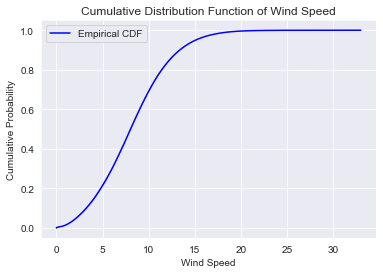

In [48]:
wind_speed = sprog['wind_speed'].dropna()  # Drop NaN values if any

# Sort the data
sorted_wind_speed = np.sort(wind_speed)

# Compute the empirical CDF
cdf = np.arange(1, len(sorted_wind_speed) + 1) / len(sorted_wind_speed)

# Plot the CDF
plt.plot(sorted_wind_speed, cdf, color="blue", label="Empirical CDF")
plt.title('Cumulative Distribution Function of Wind Speed')
plt.xlabel('Wind Speed')
plt.ylabel('Cumulative Probability')
plt.legend()

plt.savefig('Task_4_1_wind_speed_cdf_sprog.png', dpi=300)

plt.show()

#### Hovsore 1

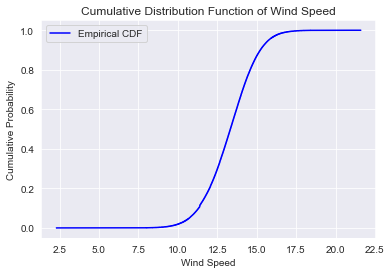

In [50]:
wind_speed = hovsore_1['sm_vel_component'].dropna() # Drop NaN values if any

# Sort the data
sorted_wind_speed = np.sort(wind_speed)

# Compute the empirical CDF
cdf = np.arange(1, len(sorted_wind_speed) + 1) / len(sorted_wind_speed)

# Plot the CDF
plt.plot(sorted_wind_speed, cdf, color="blue", label="Empirical CDF")
plt.title('Cumulative Distribution Function of Wind Speed')
plt.xlabel('Wind Speed')
plt.ylabel('Cumulative Probability')
plt.legend()

plt.savefig('Task_4_2_wind_speed_cdf_hovsore1.png', dpi=300)

plt.show()

### 5)

For the turbulence data, re-plot the PDF using normalized variables, and overplot the theo-
retical (ideal) PDF.

The turbulence data is the one corresponding to the hovsore dataset. We create a new column where the noramlised values of each dataset will be calculated

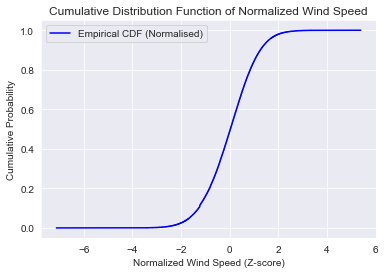

In [51]:
# Assuming wind_speed is your data (pandas Series or numpy array)
wind_speed = hovsore_1["sm_vel_component"].dropna()  # Drop NaN values if any

# Normalize the data (Z-score normalization)
mean = np.mean(wind_speed)
std = np.std(wind_speed)
normalized_wind_speed = (wind_speed - mean) / std

# Sort the normalized data
sorted_normalized_wind_speed = np.sort(normalized_wind_speed)

# Compute the empirical CDF
cdf = np.arange(1, len(sorted_normalized_wind_speed) + 1) / len(sorted_normalized_wind_speed)

# Plot the CDF
plt.plot(sorted_normalized_wind_speed, cdf, color="blue", label="Empirical CDF (Normalised)")
plt.title('Cumulative Distribution Function of Normalized Wind Speed')
plt.xlabel('Normalized Wind Speed (Z-score)')
plt.ylabel('Cumulative Probability')
plt.legend()

plt.savefig('Task_5_1_wind_speed_cdf_hovsore1_normalised.png', dpi=300)

plt.show()

### 6) 

For Sprogø data set, estimate the Webull-A and k parameters, using two different methods: 

#### Based on the first and second (non-central) moments

In [56]:
from sympy import symbols, Eq, nsolve, solve, gamma, exp

def weibull(mean, std):
    A = symbols('A')
    k = symbols('k')

    eq1 = Eq( A*gamma(1+(1/k)) , mean )
    eq2 = Eq( (A**2)* (gamma(1+(2/k)) - (gamma(1+(1/k))**2)) , std**2 ) 

    sol = nsolve((eq1,eq2), (k, A), (2, 9))
    return sol

# print(weibull(mean, std))

print(f'Shape parameter k = {weibull(sprog_ws_mean, sprog_ws_std)[0]: .3f}')
print(f'Scale parameter A = {weibull(sprog_ws_mean, sprog_ws_std)[1]: .3f}')

Shape parameter k =  2.227
Scale parameter A =  9.299


#### Based on the third moment and CDF-at-mean

In [59]:
# Assuming sprog['wind_speed'] is a Pandas DataFrame or Series
wind_speed = sprog['wind_speed'].dropna()  # Drop NaN values if any

# Calculate the mean of the wind speed
mean_wind_speed = np.mean(wind_speed)

# Sort the data
sorted_wind_speed = np.sort(wind_speed)

# Compute the CDF
cdf = np.arange(1, len(sorted_wind_speed) + 1) / len(sorted_wind_speed)

# Interpolate to get the CDF at the mean wind speed
cdf_mean = np.interp(mean_wind_speed, sorted_wind_speed, cdf)

# Define the Weibull function to solve for shape (kp) and scale (Ap) parameters
def weibullp(mean, cdf_mean):
    Ap, kp = symbols('Ap kp')  # Define variables for Ap (scale) and kp (shape)

    # Equation based on Weibull distribution formula
    eq3 = Eq((Ap**3) * gamma(1 + (3 / kp)), 962.564)  # Modify this as per your calculation
    eq4 = Eq(1 - exp(-(mean / Ap)**kp), cdf_mean)  # Weibull CDF equation

    # Solve the system of equations for kp and Ap
    sol = nsolve((eq3, eq4), (kp, Ap), (2, 9))  # (2, 9) are initial guesses for kp and Ap
    return sol

# Compute kp and Ap
sol = weibullp(mean_wind_speed, cdf_mean)

# Print the results
kp_value = sol[0]
Ap_value = sol[1]
print(f'Shape parameter kp = {kp_value:.3f}')
print(f'Scale parameter Ap = {Ap_value:.3f}')


Shape parameter kp = 2.324
Scale parameter Ap = 9.396


In [60]:
cdf_mean

0.5210079156472462

In [103]:
def equations2(params):
    A, k = params
    eq1 = A**3 * gamma(1 + 3/k) - third_moment
    eq2 = 1 - np.exp(- (sprog_ws_mean / A)**k)  # CDF at mean
    return (eq1, eq2)

# Initial guesses for A and k
initial_guess = [sprog_ws_mean, 1.5]

# Solve the equations
A_optimal, k_optimal = fsolve(equations2, initial_guess)

print(f"Estimated A: {A_optimal}, Estimated k: {k_optimal}")

Estimated A: 2.8686000777293725, Estimated k: 2.7873163321860766


/tmp/ipykernel_16661/1794734709.py:4: RuntimeWarning: invalid value encountered in scalar power
  eq2 = 1 - np.exp(- (sprog_ws_mean / A)**k)  # CDF at mean
/home/adb/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


### 7)

Based on the estimated Weibull parameters, plot the theoretical Weibull-PDFs, together
with the Sprogø data’s PDF from task 3 above.

### 8)

Investigate the Sprogø data conditioned on wind direction: divide the data into 12 directional
sectors (30 wide) and centered on 0 , 30 , ...330 (be careful around 0 ). For each sector,
calculate A and k based on one of the two methods discussed in task 6 above, and compare
the fitted Weibull-PDFs with the measured data.

In [93]:
sprog

,timestamp,wind_speed,wind_direction_67.5m,wind_direction_70m,wind_direction
0,197709131435,9.76,317.0,NaN,317.0
1,197709131445,10.58,309.0,NaN,309.0
2,197709131455,10.19,329.0,NaN,329.0
3,197709131505,8.71,323.0,NaN,323.0
4,197709131515,8.85,309.0,NaN,309.0
...,...,...,...,...,...
1156272,199909080635,4.20,NaN,222.0,222.0
1156273,199909080645,4.77,NaN,226.0,226.0
1156274,199909080655,5.37,NaN,233.0,233.0
1156275,199909080705,5.07,NaN,230.0,230.0


We create the directional bins

In [101]:
bins = np.array([0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360])
labels = np.arange(0, 360, 30)

# Assign each wind direction to a sector, including wrapping around at 360
sprog['sector'] = pd.cut(sprog['wind_direction'], bins=bins, labels=labels, right=False)

# Handle the values from 345 to 360 (assign to sector 0)
sprog.loc[(sprog['wind_direction'] >= 345) | (sprog['wind_direction'] < 15), 'sector'] = 0

In [102]:
sprog

,timestamp,wind_speed,wind_direction_67.5m,wind_direction_70m,wind_direction,sector
0,197709131435,9.76,317.0,NaN,317.0,300
1,197709131445,10.58,309.0,NaN,309.0,300
2,197709131455,10.19,329.0,NaN,329.0,300
3,197709131505,8.71,323.0,NaN,323.0,300
4,197709131515,8.85,309.0,NaN,309.0,300
...,...,...,...,...,...,...
1156272,199909080635,4.20,NaN,222.0,222.0,210
1156273,199909080645,4.77,NaN,226.0,226.0,210
1156274,199909080655,5.37,NaN,233.0,233.0,210
1156275,199909080705,5.07,NaN,230.0,230.0,210


Calculate A and k for each sector

In [104]:
results = []

def equations(params, mean, variance):
    A, k = params
    eq1 = A * gamma(1 + 1/k) - mean
    eq2 = A**2 * (gamma(1 + 2/k) - (gamma(1 + 1/k))**2) - variance
    return (eq1, eq2)

# Calculate A and k for each sector
for sector in labels:
    sector_data = sprog[sprog['sector'] == sector]['wind_speed']
    
    if len(sector_data) > 0:
        # Calculate the first moment (mean) and second moment (variance)
        sprog_ws_mean = sector_data.mean()
        sprog_variance = sector_data.var(ddof=1)  # sample variance
        
        # Initial guesses for A and k
        initial_guess = [sprog_ws_mean, 1.5]
        
        # Solve the equations
        A_optimal, k_optimal = fsolve(equations, initial_guess, args=(sprog_ws_mean, sprog_variance))
        
        # Store results
        results.append({'sector': sector, 'A': A_optimal, 'k': k_optimal})

# Create a results DataFrame
results_df = pd.DataFrame(results)

print(results_df)

    sector          A         k
0        0   7.750969  1.900057
1       30   7.525115  1.894834
2       60   7.761153  2.046636
3       90   9.236267  2.311559
4      120   9.603213  2.316891
5      150   8.461672  2.064537
6      180   9.407033  2.157974
7      210   9.931700  2.468474
8      240   9.951515  2.553114
9      270  10.194087  2.563006
10     300   9.630792  2.200351
11     330   7.896237  1.895504


### 9)

What are the seasonal and daily trends in the Sprogø data? Answer this by calculating
appropriate statistics, and produce meaningful plots.

In [105]:
sprog

,timestamp,wind_speed,wind_direction_67.5m,wind_direction_70m,wind_direction,sector
0,197709131435,9.76,317.0,NaN,317.0,300
1,197709131445,10.58,309.0,NaN,309.0,300
2,197709131455,10.19,329.0,NaN,329.0,300
3,197709131505,8.71,323.0,NaN,323.0,300
4,197709131515,8.85,309.0,NaN,309.0,300
...,...,...,...,...,...,...
1156272,199909080635,4.20,NaN,222.0,222.0,210
1156273,199909080645,4.77,NaN,226.0,226.0,210
1156274,199909080655,5.37,NaN,233.0,233.0,210
1156275,199909080705,5.07,NaN,230.0,230.0,210


#### Seasonal trends

The rows are classified depending on The season

In [106]:
sprog['timestamp'] = pd.to_datetime(sprog['timestamp'], format='%Y%m%d%H%M')

# Extract necessary time features from 'timestamp'
sprog['year'] = sprog['timestamp'].dt.year
sprog['month'] = sprog['timestamp'].dt.month
sprog['day'] = sprog['timestamp'].dt.day
sprog['hour'] = sprog['timestamp'].dt.hour
sprog['day_of_year'] = sprog['timestamp'].dt.dayofyear

# Define seasons based on the month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

sprog['season'] = sprog['month'].apply(get_season)

In [107]:
sprog

,timestamp,wind_speed,wind_direction_67.5m,wind_direction_70m,wind_direction,sector,year,month,day,hour,day_of_year,season
0,1977-09-13 14:35:00,9.76,317.0,NaN,317.0,300,1977,9,13,14,256,Fall
1,1977-09-13 14:45:00,10.58,309.0,NaN,309.0,300,1977,9,13,14,256,Fall
2,1977-09-13 14:55:00,10.19,329.0,NaN,329.0,300,1977,9,13,14,256,Fall
3,1977-09-13 15:05:00,8.71,323.0,NaN,323.0,300,1977,9,13,15,256,Fall
4,1977-09-13 15:15:00,8.85,309.0,NaN,309.0,300,1977,9,13,15,256,Fall
...,...,...,...,...,...,...,...,...,...,...,...,...
1156272,1999-09-08 06:35:00,4.20,NaN,222.0,222.0,210,1999,9,8,6,251,Fall
1156273,1999-09-08 06:45:00,4.77,NaN,226.0,226.0,210,1999,9,8,6,251,Fall
1156274,1999-09-08 06:55:00,5.37,NaN,233.0,233.0,210,1999,9,8,6,251,Fall
1156275,1999-09-08 07:05:00,5.07,NaN,230.0,230.0,210,1999,9,8,7,251,Fall


#### Daily Trends

We calculate the mean wind speed and wind direction by hour of the day

In [ ]:
daily_trends = sprog.groupby('hour').agg(
    mean_wind_speed=('wind_speed', 'mean'),
    mean_wind_direction=('wind_direction', 'mean')
).reset_index()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your dataframe is called 'sprog'
# Convert 'timestamp' from string format to datetime
sprog['timestamp'] = pd.to_datetime(sprog['timestamp'], format='%Y%m%d%H%M')

# Extract necessary time features from 'timestamp'
sprog['year'] = sprog['timestamp'].dt.year
sprog['month'] = sprog['timestamp'].dt.month
sprog['day'] = sprog['timestamp'].dt.day
sprog['hour'] = sprog['timestamp'].dt.hour
sprog['day_of_year'] = sprog['timestamp'].dt.dayofyear

# Define seasons based on the month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

sprog['season'] = sprog['month'].apply(get_season)

# 1. Daily trends: calculate mean wind speed and wind direction by hour of the day
daily_trends = sprog.groupby('hour').agg(
    mean_wind_speed=('wind_speed', 'mean'),
    mean_wind_direction=('wind_direction', 'mean')
).reset_index()

# Plot daily wind speed trend
plt.figure(figsize=(10, 6))
sns.lineplot(x='hour', y='mean_wind_speed', data=daily_trends, marker='o')
plt.title('Daily Trend of Wind Speed')
plt.xlabel('Hour of the Day')
plt.ylabel('Mean Wind Speed')
plt.grid(True)
plt.show()

# Plot daily wind direction trend
plt.figure(figsize=(10, 6))
sns.lineplot(x='hour', y='mean_wind_direction', data=daily_trends, marker='o')
plt.title('Daily Trend of Wind Direction')
plt.xlabel('Hour of the Day')
plt.ylabel('Mean Wind Direction (degrees)')
plt.grid(True)
plt.show()

# 2. Seasonal trends: calculate mean wind speed and wind direction by season
seasonal_trends = sprog.groupby('season').agg(
    mean_wind_speed=('wind_speed', 'mean'),
    mean_wind_direction=('wind_direction', 'mean')
).reset_index()

# Plot seasonal wind speed trend
plt.figure(figsize=(10, 6))
sns.barplot(x='season', y='mean_wind_speed', data=seasonal_trends)
plt.title('Seasonal Trend of Wind Speed')
plt.xlabel('Season')
plt.ylabel('Mean Wind Speed')
plt.grid(True)
plt.show()

# Plot seasonal wind direction trend
plt.figure(figsize=(10, 6))
sns.barplot(x='season', y='mean_wind_direction', data=seasonal_trends)
plt.title('Seasonal Trend of Wind Direction')
plt.xlabel('Season')
plt.ylabel('Mean Wind Direction (degrees)')
plt.grid(True)
plt.show()

# 3. Calculate statistics: mean, median, variance, and standard deviation for wind speed and direction
statistics = sprog.agg({
    'wind_speed': ['mean', 'median', 'var', 'std'],
    'wind_direction': ['mean', 'median', 'var', 'std']
})

print("Statistics for Wind Speed and Wind Direction:")
print(statistics)
